# Load the trained CNN model and label images 

In [1]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from skimage import data,io,filters,draw,util
import os
from skimage.io import imread #smaller part from skimage
%matplotlib inline
from IPython.display import clear_output, display
import pandas as pd
from skimage.morphology import convex_hull_image, erosion, opening, closing, disk
from shutil import copyfile #for making folder
from skimage.filters import rank
import skimage
from skimage import data,io,filters
from skimage import exposure

In [5]:
def generate_mask(image, width=550, train=False):
    mask = image
    if width%2!=0:
        width=width-1
    mask = mask<mask.max()*.9
    mask = opening(mask,disk(5))
    mask = convex_hull_image(mask)
    middle_of_core=[]
    for y in range(mask.shape[0]):
        if np.sum(np.where(mask[y,:]))>0:
            middle_of_core.append(np.mean(np.where(mask[y,:])))
    middle_of_core = np.mean(middle_of_core).astype(int)

    if train==False:
        mask2 = np.zeros(mask.shape)
        for y in range(mask.shape[0]):
            if np.sum(mask[y,:])>0:
                left = np.array(middle_of_core-width/2).astype(int)
                right = np.array(middle_of_core+width/2).astype(int)
                mask2[y,left:right]=1
        return mask*mask2
    else:
        return mask

def clear_edges(im,side_size): 
    im=np.copy(im) 
    im[:int(side_size/2),:]=-1
    im[-1*int(side_size/2):,:]=-1
    im[:,:int(side_size/2)]=-1
    im[:,-1*int(side_size/2):]=-1
    return im

def label_image_thresh(im,model,minval,maxval): 
    memory_buffer = 2000 
    im2=clear_edges(np.copy(im),side_size)
    # Equalization
    selem = disk(50)
    img_eq = rank.equalize(im2/np.max(im2), selem=selem)
    img_eq = clear_edges(np.copy(img_eq),side_size)
    xv, yv = np.where(img_eq<100)
    print(xv.size)
    xv=np.array(xv).ravel()
    yv=np.array(yv).ravel()
    L2=np.zeros(im.shape)-1
    for i in range(0,xv.size,memory_buffer):
        clear_output()
        if i+memory_buffer<xv.size:
            x_tiny=xv[i:i+memory_buffer]
            y_tiny=yv[i:i+memory_buffer]
        else:
            x_tiny=xv[i:]
            y_tiny=yv[i:]
        to_label_X= np.array([im[int(x-side_size/2):int(x+side_size/2),
                            int(y-side_size/2):int(y+side_size/2)]
                              for x,y in zip(x_tiny,y_tiny)])
        to_label_X=to_label_X.reshape(-1,side_size,side_size,1)
        to_label_X = (to_label_X-minval)/(maxval-minval) 
       
        print('Labeling pixels '+str(i)+' to '
              +str(i+memory_buffer)+' out of '+str(xv.size)+'.\n')
        L=np.argmax(model.predict(to_label_X,verbose=0),axis=1)
   
        i=0
        for x,y in zip(x_tiny,y_tiny):
            L2[x,y]=L[i]
            i+=1
    return L2

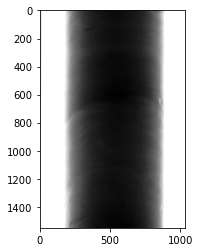

In [3]:
#model core
im = imread('382-U1537D-48F-1-A_820-980_SHLF9956601_20190503000844_k60_a1_t350_n20_RAW.tif')
plt.imshow(im, cmap = 'Greys_r')

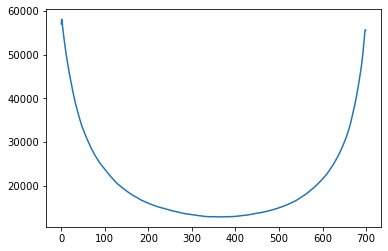

In [4]:
def create_filter(im):
    crop = im[0:im.shape[0], 100:1000]
    mask = crop
    mask = mask<mask.max()*.9
    mask = opening(mask,disk(5))
    mask = convex_hull_image(mask)
    create_mask = mask*1
    new_im = crop*create_mask
    ndf = pd.DataFrame(data = new_im)
    ndf = ndf.mean(axis=0)
    filt = np.asarray(ndf)
    return filt
filt = create_filter(im)
start = filt[75]
end = filt[785]
newfilt = filt[80:780]
x = np.arange(len(newfilt))
plt.plot(x,newfilt)

## the raw images have a slight gray region in top left
## that messes with the masking 

newx = len(newfilt)/2

def picprep(im1):
    whiteout = path.endswith('RAW.tif')
    if whiteout==True:
        im1[0:im1.shape[0], 0:100] = 65535
        return im1
    else:
        return im1

def NEWapplyfilter(im1):
    mask =  im1
    mask = mask<mask.max()*.9
    wherecore = np.sum(mask, axis = 1)
    mask[wherecore<450,:] = False
    
    mask = opening(mask,disk(5))
    mask = convex_hull_image(mask)
    
    middle_of_core=[]
    for y in range(mask.shape[0]):
        if np.sum(np.where(mask[y,:]))>0:
            middle_of_core.append(np.mean(np.where(mask[y,:])))
    middle_of_core = np.mean(middle_of_core).astype(int)
    
    xmin = (middle_of_core - newx).astype(np.int64) 
    xmax = (middle_of_core + newx).astype(np.int64)
    
    left = (im1[0:im1.shape[0], 0:xmin]).astype('float64')
    right = (im1[0:im1.shape[0], xmax:len(im1[0])]).astype('float64')
    filtered = im1[0:im1.shape[0], xmin:xmax] - newfilt
    newim = np.concatenate((left,filtered,right), axis = 1)
    
    nnewim = newim - newim.min()
    trynew = nnewim / nnewim.max()
    finalim = (trynew * 65535).astype('uint16')
    imeq = exposure.equalize_adapthist(finalim, clip_limit=0.04)
    imeq = (imeq * 65535).astype('uint16')
    return imeq

def NEWcreateimage(im1):
    finim = picprep(im1)
    finim = NEWapplyfilter(finim)
    return finim

## Example of Raw to Enhanced Image 

In [128]:
# all of this code is in the NEWapplyfilter function, these function is 
# just to demonstrate the flattening step 
def setup_flattenimage(im1):
    mask =  im1
    mask = mask<mask.max()*.9
    wherecore = np.sum(mask, axis = 1)
    mask[wherecore<450,:] = False
    
    mask = opening(mask,disk(5))
    mask = convex_hull_image(mask)
    
    middle_of_core=[]
    for y in range(mask.shape[0]):
        if np.sum(np.where(mask[y,:]))>0:
            middle_of_core.append(np.mean(np.where(mask[y,:])))
    middle_of_core = np.mean(middle_of_core).astype(int)
    
    xmin = (middle_of_core - newx).astype(np.int64) 
    xmax = (middle_of_core + newx).astype(np.int64)
    
    left = (im1[0:im1.shape[0], 0:xmin]).astype('float64')
    right = (im1[0:im1.shape[0], xmax:len(im1[0])]).astype('float64')
    filtered = im1[0:im1.shape[0], xmin:xmax] - newfilt
    newim = np.concatenate((left,filtered,right), axis = 1)
    
    nnewim = newim - newim.min()
    trynew = nnewim / nnewim.max()
    imeq = (trynew * 65535).astype('uint16')
    return imeq
def flattenimage(im1):
    finim = picprep(im1)
    finim = setup_flattenimage(im1)
    return finim

In [5]:
path = '382-U1537D-9H-5-A_100-260_SHLF9946101_20190430194104_k60_a1_t350_n20_RAW.tif'
im = imread(path)

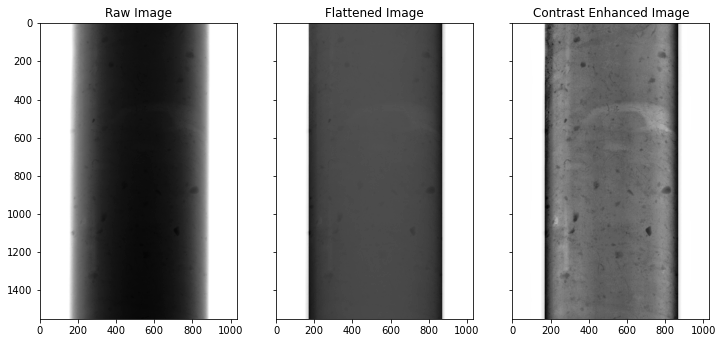

In [136]:
fig, ax =plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize=(12,7))
ax[0].imshow(im, cmap = 'Greys_r')
ax[0].title.set_text("Raw Image")
ax[1].imshow(flattenimage(im), cmap = 'Greys_r')
ax[1].title.set_text("Flattened Image")
ax[2].imshow(NEWcreateimage(im), cmap = 'Greys_r')
ax[2].title.set_text("Contrast Enhanced Image")
plt.show()

## Load model 

In [6]:
from tensorflow.keras.models import load_model
model = load_model('04_63_epoch_8639-43402.h5')
maxval= 43402
minval= 8639
side_size= 128 

## Testing Out Single Images

In [137]:
def label_and_plot(path):
    im = imread(path)
    im = NEWcreateimage(im)
    im = im*(generate_mask(im,width=550,train=False))
    label_test_output = label_image_thresh(im,model,minval,maxval)
    im_out = label_test_output
    cmap = colors.ListedColormap(["#FFFFFF00", 'red'])
    bounds=[-1,0.6,1.0]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig, ax =plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(12,7))
    ax[0].imshow(im, cmap = "Greys_r")
    ax[0].title.set_text("Contrast Enhanced Image")
    ax[1].imshow(im, cmap = "Greys_r")
    ax[1].imshow(im_out, cmap=cmap, norm=norm)
    ax[1].title.set_text("IRD Labeled Image")
    fig.tight_layout(w_pad= -25,h_pad=0)

Labeling pixels 252000 to 254000 out of 252354.



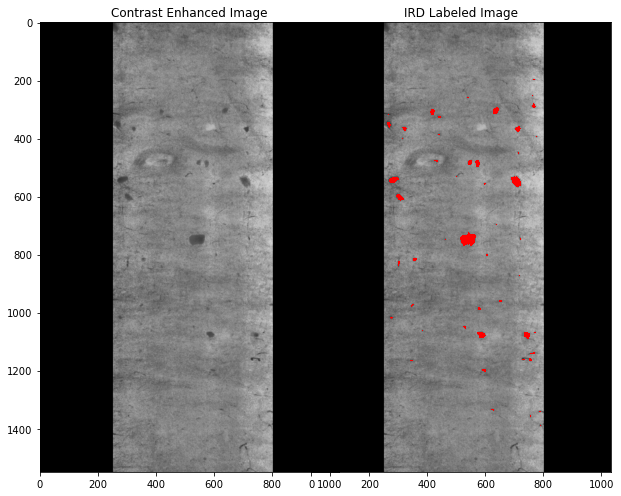

In [138]:
# a few example images from U1537 to show the process of labeling a single image
# U1537A-16H-6-A_700-860cm # 
path = '/local/data/EXP_382/U1537/Hole A/16H/6/382-U1537A-16H-6-A_700-860_SHLF9929711_20190428140650_k60_a1_t400_n20_RAW.tif'
label_and_plot(path)

Labeling pixels 246000 to 248000 out of 247619.



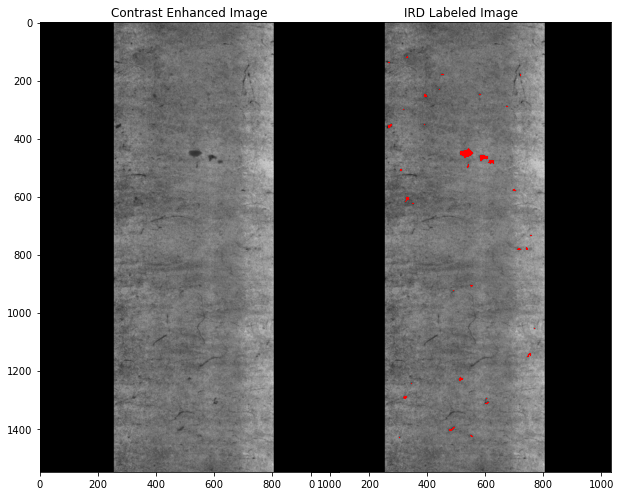

In [139]:
# U1537A-16H-6-A_820-980cm # 
path = '/local/data/EXP_382/U1537/Hole A/16H/6/382-U1537A-16H-6-A_820-980_SHLF9929711_20190428140703_k60_a1_t400_n20_RAW.tif'
label_and_plot(path)

Labeling pixels 246000 to 248000 out of 247619.



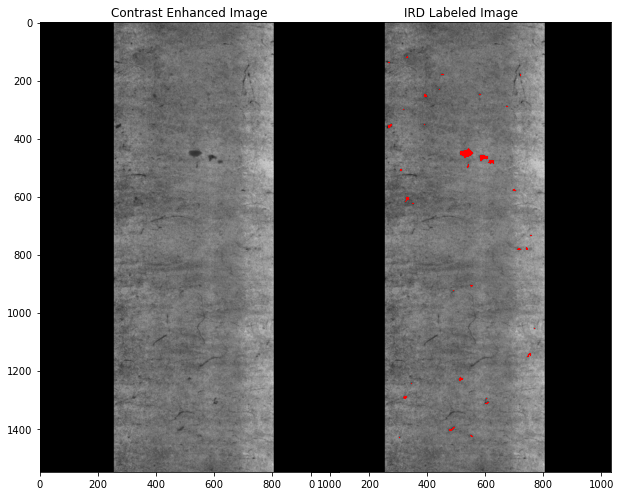

In [140]:
# U1537A-16H-6-A_820-980cm # 
path = '/local/data/EXP_382/U1537/Hole A/16H/6/382-U1537A-16H-6-A_820-980_SHLF9929711_20190428140703_k60_a1_t400_n20_RAW.tif'
label_and_plot(path)

Labeling pixels 250000 to 252000 out of 250743.



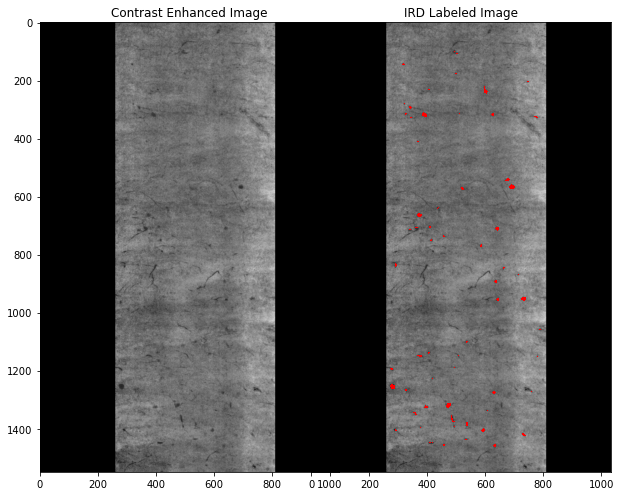

In [141]:
# U1537A-16H-6-A_940-1100cm # 
path = '/local/data/EXP_382/U1537/Hole A/16H/6/382-U1537A-16H-6-A_940-1100_SHLF9929711_20190428140717_k60_a1_t400_n20_RAW.tif'
label_and_plot(path)

Labeling pixels 252000 to 254000 out of 252460.



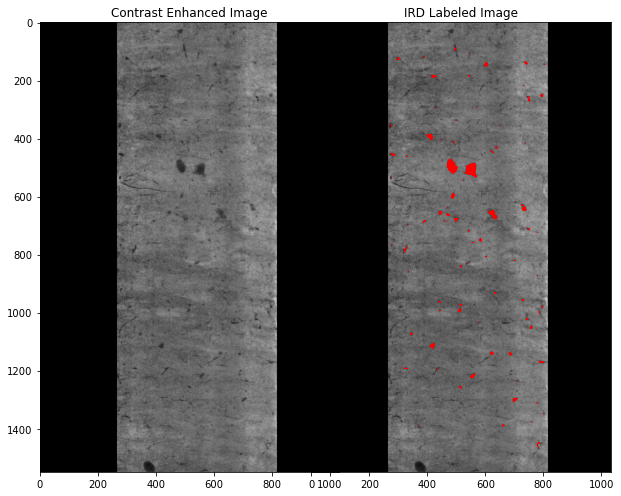

In [142]:
# U1537A-16H-6-A_1060-1220cm # 
path = '/local/data/EXP_382/U1537/Hole A/16H/6/382-U1537A-16H-6-A_1060-1220_SHLF9929711_20190428140731_k60_a1_t400_n20_RAW.tif'
label_and_plot(path)

Labeling pixels 250000 to 252000 out of 251477.



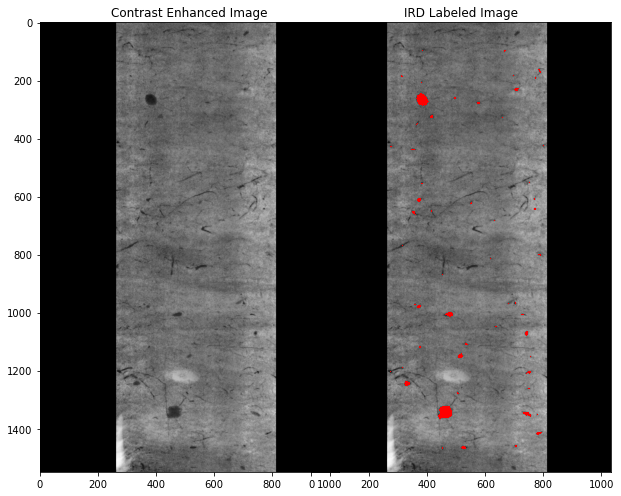

In [143]:
# U1537A-16H-6-A_1180-1340cm # 
path = '/local/data/EXP_382/U1537/Hole A/16H/6/382-U1537A-16H-6-A_1180-1340_SHLF9929711_20190428140745_k60_a1_t400_n20_RAW.tif'
label_and_plot(path)

## Load a Splice Table and Label X-ray Images Down the Splice

In [144]:
#U1537 splice table
spliced = pd.read_csv('/local/data/EXP_382/EXP382/2_LOAD_MODEL_TAG_IMAGES/data/F23_U1537_reillysplice.csv')

In [146]:
# FOR U1537: 
ROWSTORUN = np.array([np.arange(0,71)]).ravel()

In [147]:
#TAGGING THE EXP 382 IMAGES 

allcompdirlist=[]
CCSFtop=[]
CCSFbottom=[]
for row in ROWSTORUN:
    directory1='/local/data/EXP_382/U1537/'
    directory2='Hole '+spliced['Hole'].values[row]+'/'
    directory3=spliced['Core'].values[row].astype(str)+spliced['Core Type'].values[row]+'/'
    sections=np.arange(spliced['Top Section'].values[row],spliced['Bottom Section'].values[row]+1).astype(str) 
    compdirlist=[directory1+directory2+directory3+section+'/' for section in sections]
    allcompdirlist.append(compdirlist)
    CCSFtop.append(spliced['Top Depth (mcd)'].values[row])
    CCSFbottom.append(spliced['Bottom Depth (mcd)'].values[row])

In [148]:
allcompdirlist #to check if there all selected

[['/local/data/EXP_382/U1537/Hole B/1H/1/',
  '/local/data/EXP_382/U1537/Hole B/1H/2/',
  '/local/data/EXP_382/U1537/Hole B/1H/3/',
  '/local/data/EXP_382/U1537/Hole B/1H/4/'],
 ['/local/data/EXP_382/U1537/Hole A/2H/3/',
  '/local/data/EXP_382/U1537/Hole A/2H/4/',
  '/local/data/EXP_382/U1537/Hole A/2H/5/',
  '/local/data/EXP_382/U1537/Hole A/2H/6/'],
 ['/local/data/EXP_382/U1537/Hole D/2H/3/',
  '/local/data/EXP_382/U1537/Hole D/2H/4/',
  '/local/data/EXP_382/U1537/Hole D/2H/5/',
  '/local/data/EXP_382/U1537/Hole D/2H/6/'],
 ['/local/data/EXP_382/U1537/Hole A/3H/1/',
  '/local/data/EXP_382/U1537/Hole A/3H/2/',
  '/local/data/EXP_382/U1537/Hole A/3H/3/',
  '/local/data/EXP_382/U1537/Hole A/3H/4/',
  '/local/data/EXP_382/U1537/Hole A/3H/5/',
  '/local/data/EXP_382/U1537/Hole A/3H/6/'],
 ['/local/data/EXP_382/U1537/Hole D/3H/4/',
  '/local/data/EXP_382/U1537/Hole D/3H/5/'],
 ['/local/data/EXP_382/U1537/Hole A/4H/1/',
  '/local/data/EXP_382/U1537/Hole A/4H/2/',
  '/local/data/EXP_382/U153

In [81]:
from skimage.io import imsave

for directory in allcompdirlist:
    for folder in directory:
        files=os.listdir(folder)
        for f in files:
            if f[0]!='.':
                im = imread(folder+f)
                im = NEWcreateimage(im)
                im = im*(generate_mask(im,width=550,train=False))
                label_test_output = label_image_thresh(im,model,minval,maxval)
                im_out = label_test_output
                imsave('/local/data/EXP_382/outputs_U1537/'+f,im_out) 

Labeling pixels 228000 to 230000 out of 228438.



In [82]:
#Put all labeled images back into core and section folders
folder_path = '/local/data/EXP_382/outputs_U1537' 
os.chdir(folder_path)
for file in os.listdir(folder_path):
    if file[0]!='.':
        if not os.path.isdir(file):
            Hole = 'Hole'+ ' ' +file[9]         
            Core = "".join(filter(str.isdigit, file[10:14])) + "".join(filter(str.isalpha, file[10:14])) + "/"
            Section = "".join(filter(str.isdigit, file[14:16])) + "/"
  
            final_path = folder_path + '/' + Hole + '/' + Core + '/' + Section + '/'
            try:
                copyfile(file, final_path+file)
            except FileNotFoundError:
                if not os.path.exists(Hole): #doesn't exist
                    os.mkdir(Hole)
                if not os.path.exists(Hole + '/' + Core):
                    os.mkdir(Hole + '/' + Core)
                if not os.path.exists(Hole + '/' + Core + '/' + Section):
                    os.mkdir(Hole + '/' + Core + '/' + Section)
                copyfile(file, final_path+file)
        